In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
from models.losses import SupervisedSimCLRLoss
#from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel
import data.data_utils as dutils

In [2]:
npart=2
nrand=15
nj_train   = 10000
nj_valid   = 5
nj_testy   = 10000
tjds       = datasets.FlatDataset(npart,nj_train,nj_valid,nj_testy,nrand=nrand)
input_dim  = tjds.train_data.shape[1]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


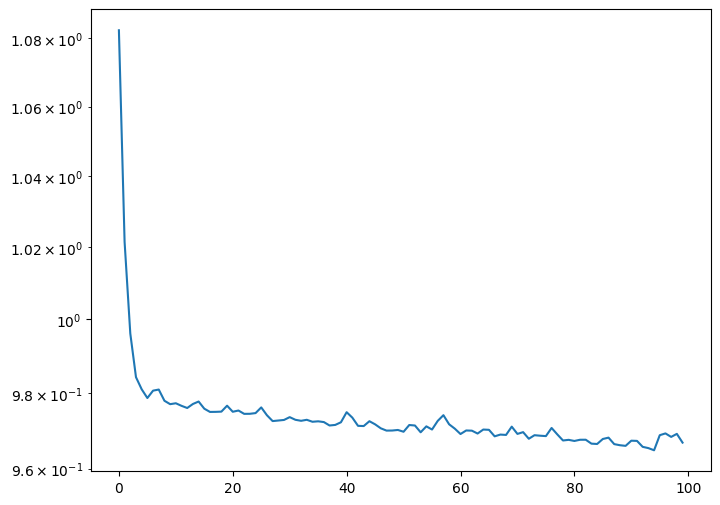

3
Accuracy: tensor(0.6111)


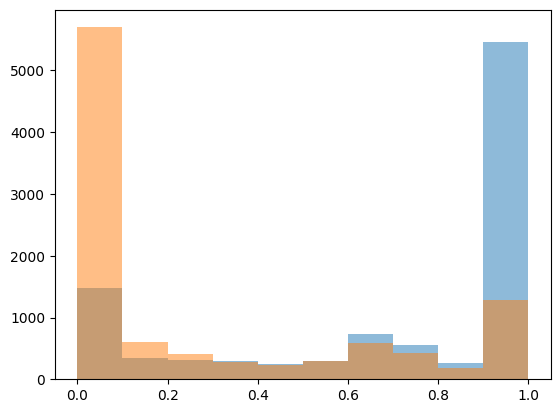

3
Accuracy: tensor(0.5862)


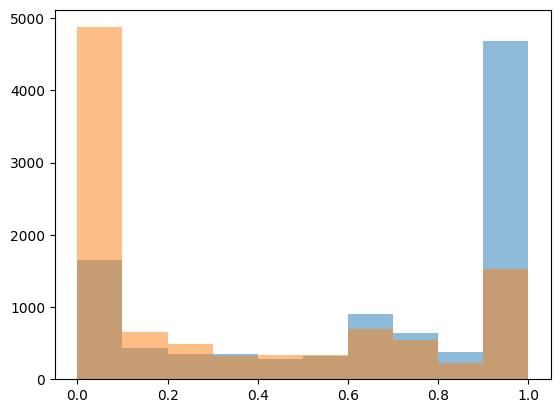

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.00it/s]


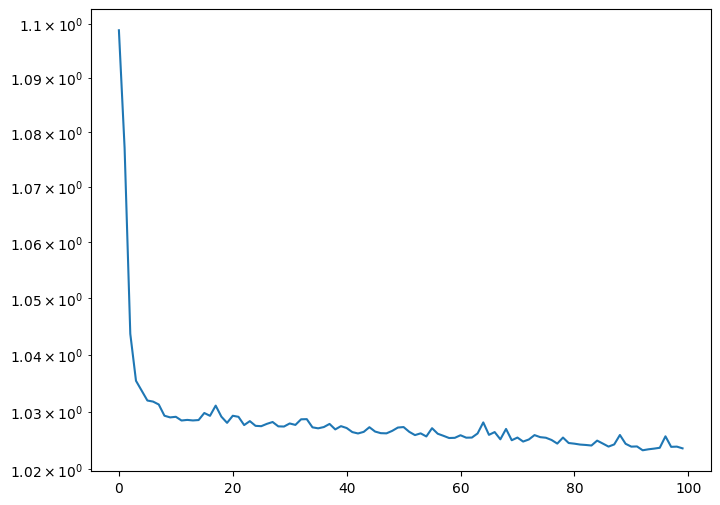

3
Accuracy: tensor(0.5925)


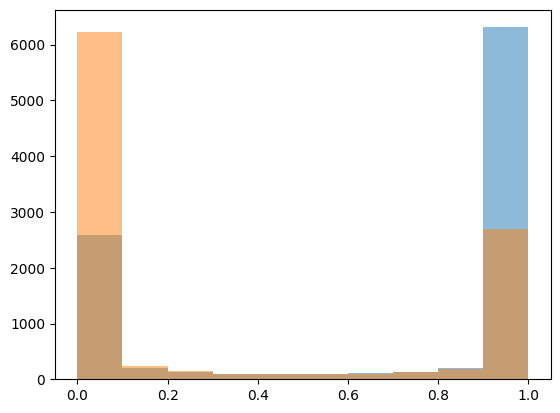

In [3]:
last_dim=4
batch_size=2000
disc_trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
disc_model=dutils.train_disc(100,disc_trainloader,input_dim,last_dim)
plt.show()
dutils.check_disc(tjds.test_data,tjds.test_labels,disc_model)
plt.show()
dutils.check_disc(tjds.trut_data,tjds.trut_labels,disc_model)
plt.show()

disc_trainloader = torch.utils.data.DataLoader(tjds.true_dataset_basic, batch_size=batch_size, shuffle=True)
disc_model_data=dutils.train_disc(100,disc_trainloader,input_dim,last_dim)
plt.show()
dutils.check_disc(tjds.trut_data,tjds.trut_labels,disc_model_data)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]


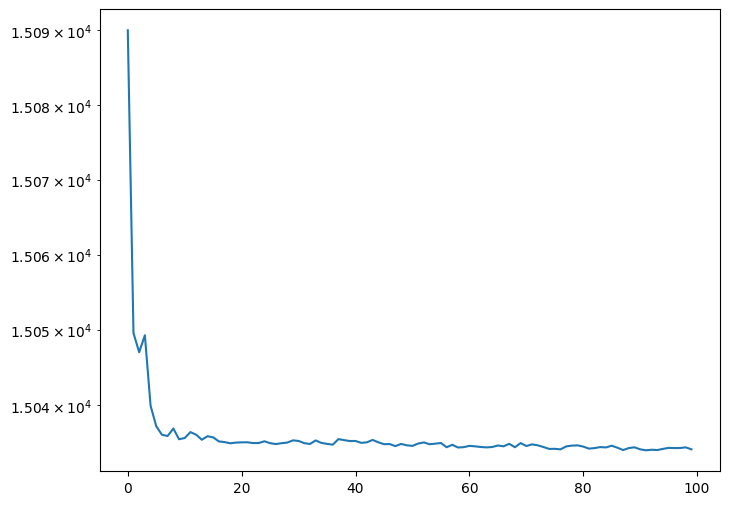

1
torch.Size([20000])
Accuracy: tensor(0.6362)


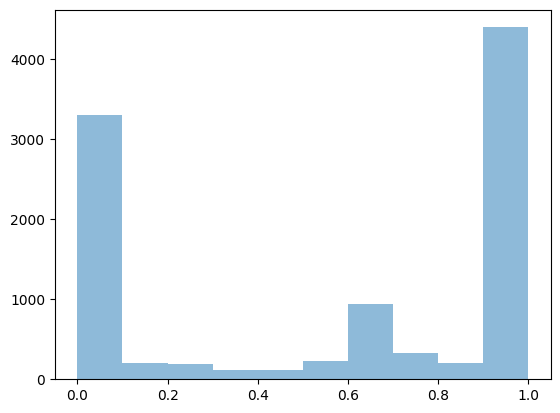

1
torch.Size([20000])
Accuracy: tensor(0.5797)


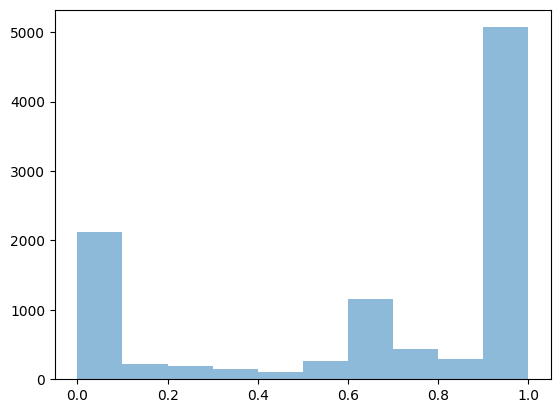

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.29it/s]


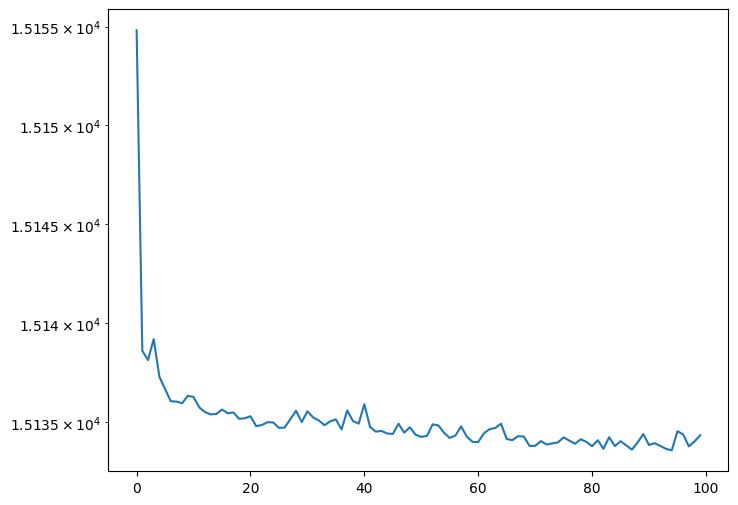

1
torch.Size([20000])
Accuracy: tensor(0.6001)


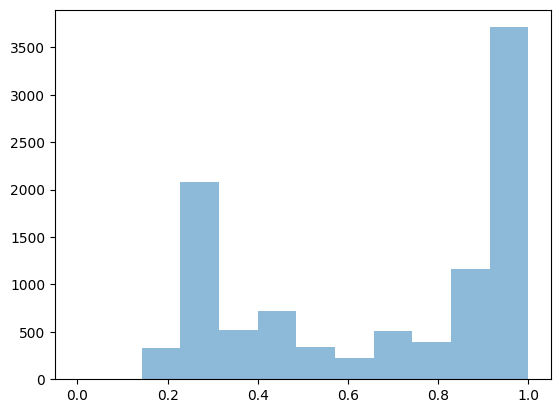

In [4]:
labels =tjds.test_labels
labels1=tjds.true_labels
with torch.no_grad():
    outputt   = (disc_model.forward_ll(tjds.train_data.float()))
    outputt1  = (disc_model.forward_ll(tjds.true_data.float()))
    output    = (disc_model.forward_ll(tjds.test_data.float()))
    output1   = (disc_model.forward_ll(tjds.trut_data.float()))

#import corner
#import matplotlib.lines as mlines
#fig = plt.figure(figsize=(8,8))
#corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
#corner.corner(output[labels==1].numpy(),fig=fig,color="C2", label='signal')
#corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='background')
#corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal')
#plt.legend(
#        handles=[
#            mlines.Line2D([], [], color="C0", label='background'),
#            mlines.Line2D([], [], color="C2", label='signal'),
#            mlines.Line2D([], [], color="C1", label='data signal'),
#        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
#    )
#plt.show()

trainspace=dutils.GenericDataset(outputt[labels!=1],labels[labels!=1])
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_nctr=dutils.train_disc(100,trainloader,output.shape[1],output_dim=1)
plt.show()
tlabels=tjds.test_labels
dutils.check_disc(output[tlabels!=1],tlabels[tlabels!=1],disc_model_nctr)
plt.show()
trlabels=tjds.trut_labels
dutils.check_disc(output1[trlabels!=1],trlabels[trlabels!=1],disc_model_nctr)
#dutils.check_disc(output1,tjds.trut_labels,disc_model_nctr)
plt.show()


trainspace=dutils.GenericDataset(outputt1[labels1!=1],labels1[labels1!=1])
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_bctr=dutils.train_disc(100,trainloader,output1.shape[1],output_dim=1)
plt.show()
trlabels=tjds.trut_labels
dutils.check_disc(output1[trlabels!=1],trlabels[trlabels!=1],disc_model_bctr)
plt.show()

In [5]:
hidden_dims= [128,64,32,16]
embed_dim  = 8
temp = 0.1
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-2)

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:50<00:00,  2.21s/it]


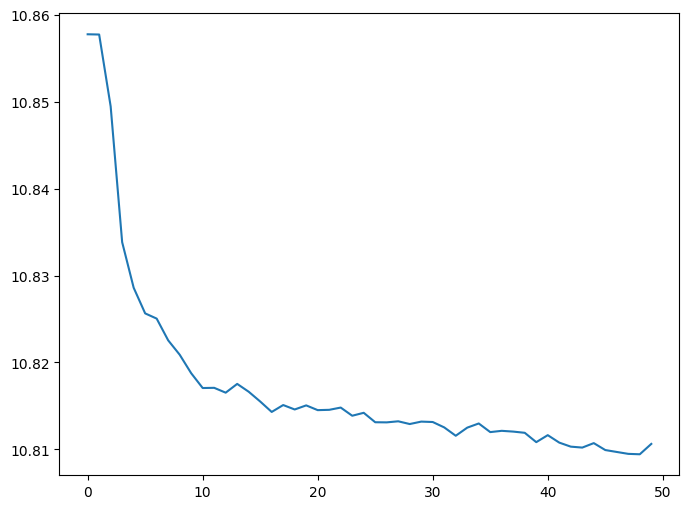

In [6]:
# Training loop
num_epochs = 50
batch_size = 2000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

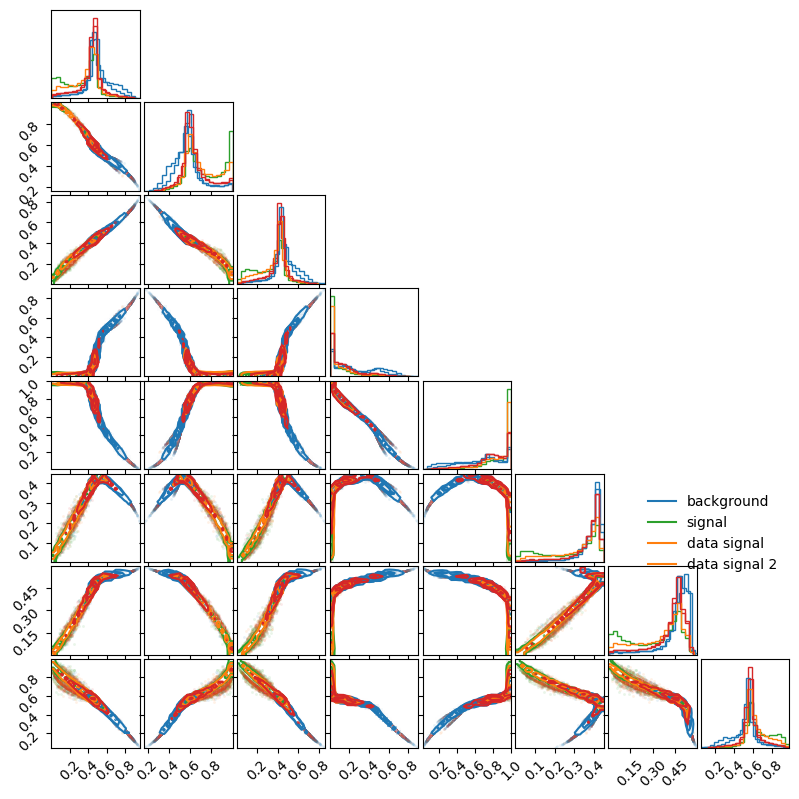

In [7]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True).numpy())
    output1 = (model(tjds.true_data.float(),embed=True).numpy())

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0", label='background')
corner.corner(output[labels==1],fig=fig,color="C2", label='signal')
corner.corner(output[labels==2],fig=fig,color="C3", label='signal 2')
corner.corner(output1[labels1==0],fig=fig,color="C0", label='background')
corner.corner(output1[labels1==1],fig=fig,color="C1", label='data signal')
corner.corner(output1[labels1==2],fig=fig,color="C3", label='data signal 2')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C2", label='signal'),
            mlines.Line2D([], [], color="C1", label='data signal'),
            mlines.Line2D([], [], color="C1", label='data signal 2'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


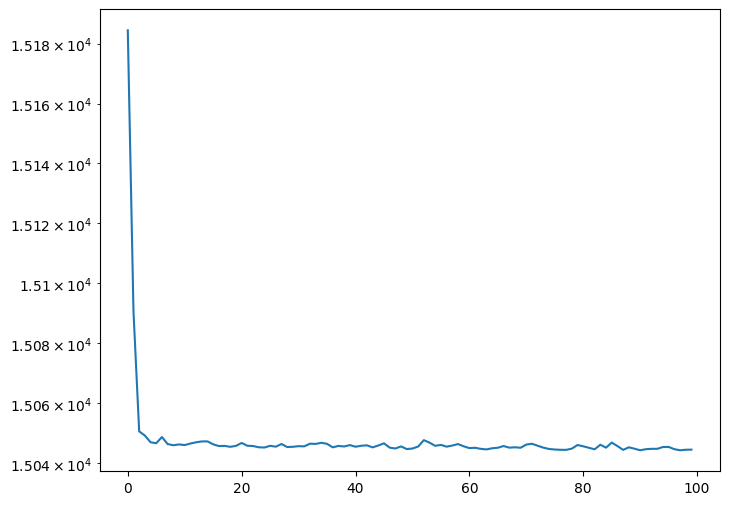

1
torch.Size([20000])
Accuracy: tensor(0.6334)


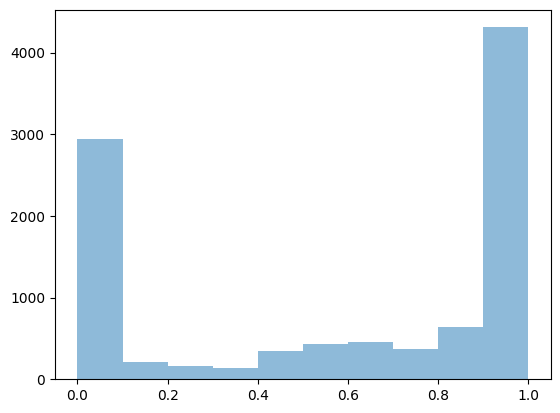

1
torch.Size([20000])
Accuracy: tensor(0.5777)


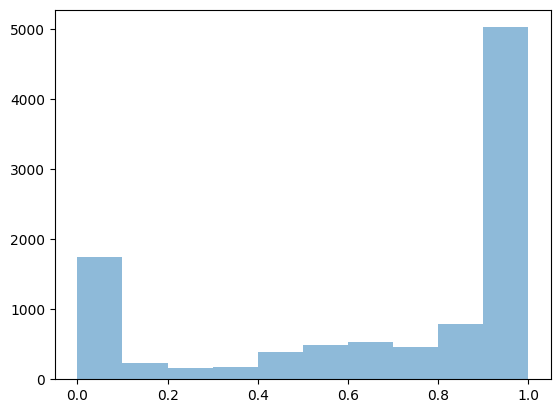

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


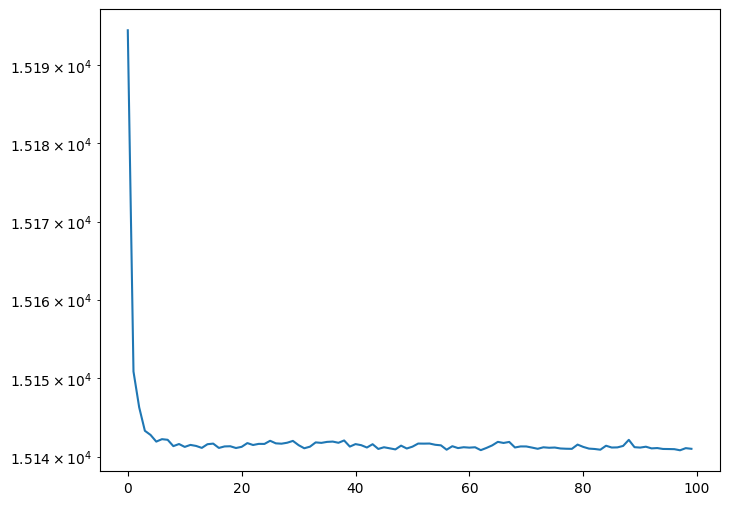

1
torch.Size([20000])
Accuracy: tensor(0.5978)


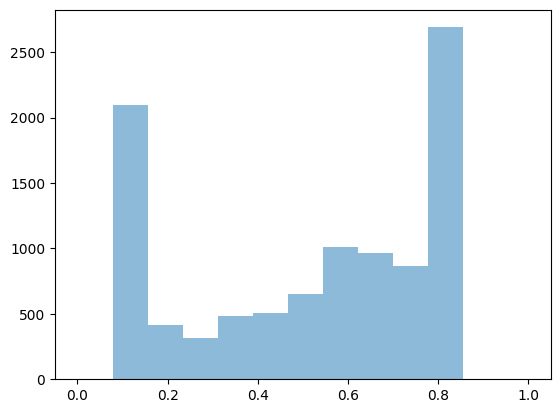

In [8]:
labels =tjds.test_labels
labels1=tjds.true_labels
with torch.no_grad():
    outputt  = (model(tjds.train_data.float(),embed=True))
    outputt1 = (model(tjds.true_data.float(),embed=True))
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.trut_data.float(),embed=True))

trainspace=dutils.GenericDataset(outputt[labels!=1],labels[labels!=1])
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_ctr=dutils.train_disc(100,trainloader,output.shape[1],output_dim=1)
plt.show()
tlabels=tjds.test_labels
trlabels=tjds.trut_labels
dutils.check_disc(output[tlabels!=1],tlabels[tlabels!=1],disc_model_ctr)
plt.show()
dutils.check_disc(output1[trlabels!=1],trlabels[trlabels!=1],disc_model_ctr)
plt.show()


trainspace=dutils.GenericDataset(outputt1[labels1!=1],labels1[labels1!=1])
trainloader = torch.utils.data.DataLoader(trainspace, batch_size=batch_size, shuffle=True)
disc_model_ctr=dutils.train_disc(100,trainloader,output1.shape[1],output_dim=1)
plt.show()
dutils.check_disc(output1[trlabels!=1],trlabels[trlabels!=1],disc_model_ctr)
plt.show()

In [23]:
print(input_dim)

21


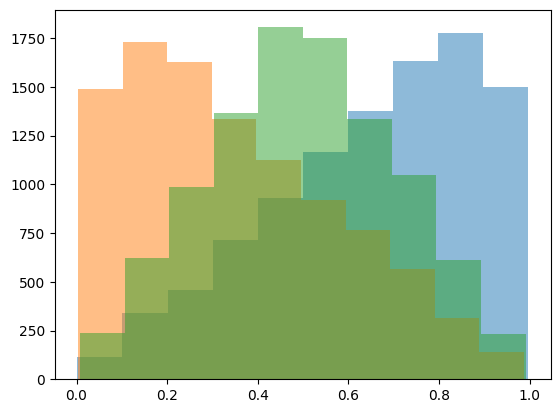

In [20]:
nsig=10000
val=0.05
sig=np.random.triangular(0.,1.-val, 1, nsig)
bkg=np.random.triangular(0.,val, 1, nsig)
sig1=np.random.triangular(0.,0.5, 1, nsig)
plt.hist(sig,alpha=0.5)
plt.hist(bkg,alpha=0.5)
plt.hist(sig1,alpha=0.5)
plt.show()

In [16]:
y = torch.randint(0, 3, (500,))
print(y)

tensor([2, 0, 1, 2, 2, 0, 2, 1, 2, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 2, 2, 1, 2, 1,
        0, 2, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 2,
        1, 2, 0, 1, 0, 1, 2, 0, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0,
        2, 0, 1, 1, 1, 1, 0, 2, 2, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 0, 2, 2, 1,
        0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 2, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 0, 0, 2,
        1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1, 0, 2, 1, 1, 1, 0, 2,
        0, 0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0,
        0, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 0, 2, 2, 1, 1, 2,
        1, 2, 0, 1, 2, 1, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 0,
        1, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 2, 2, 1,
        0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 1,

In [9]:
np.random.uniform(0.01,1,10)

array([0.71518975, 0.50548858, 0.01024276, 0.78675125, 0.60189886,
       0.51744991, 0.18559006, 0.51550868, 0.09160105, 0.61871467])